**ABSTRACT**

Implementation of the Kinetic Component Analysis algorhitm By Marcos Lopez de Prado and Riccardo Rebonato on future contract prices

Source: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2422183

**OUTLINE OF THE NOTEBOOK** 

1. Importing data from yfinance and data preprocessing
2. Kinetic component analysis
3. Generate trading signals from KCA
4. Construct trading strategy for the end user
5. Conclusions





**1. IMPORTING DATA FROM YFINANCE AND DATA PREPROCESSING**

Using 1 year of daily closing price of some of the futures used by the authors. The authors apply KCA on the series of
volume weighted average prices (VWAP), so in the preprocessing we obtain VWAP from yahoo tickers data

In [2]:
!pip install yfinance
!pip install pykalman
import numpy as np
import yfinance as yf
import pandas as pd
import math, sys
import matplotlib as plt
import matplotlib.pyplot as pp
from pykalman import KalmanFilter
from math import floor

     |████████████████████████████████| 6.3 MB 13.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=1b6c78ea96c60c0dc31087fdae60231cdee319ef681deed4e4425ded6a8d522e
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 228 kB 10.2 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=18cfa27d2cee05a1b159fd637d98a3d8b389332fef152c29fc66a43998028d53
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman


In [71]:
def vwap(df):
    q = df.Volume.values
    p = df.Open.values
    return df.assign(vwap=(p * q).cumsum() / q.cumsum())

In [104]:
def price(tickers, startdate, enddate):
    df = yf.download(tickers,startdate,enddate)
    price = df.groupby(df.index.date, group_keys=False).apply(vwap) #calculating vwap
    price = price.reset_index()
    price['Date'] = pd.to_datetime(price['Date'])
    price['Date'] = pd.DatetimeIndex(price['Date']).floor('d').to_julian_date()
    price['Pct'] = price['Close'].pct_change() # calculating daily percentage change in price
    price['Returns'] = (price['Pct'] + 1).cumprod() # calculating returns from the start period of observation
    price = price.dropna() # deleting the first row
    array = np.array(price)
    return array

In [105]:
tickers = ['CL=F'] #Other futures used in the article 'NG=F', 'SI=F', 'GC=F', 'ZC=F'
startdate = '2020-01-01'
enddate =  '2020-12-31'
price = price(tickers, startdate, enddate)

[*********************100%***********************]  1 of 1 completed


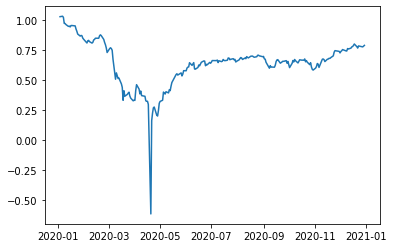

In [106]:
#Plot returns over time
color=['b']
p = price[:, 9]
t = price[:, 0]
epoch = pd.to_datetime(0, unit='s').to_julian_date()
t = pd.to_datetime(t - epoch, unit='D')
pp.plot(t,p,linestyle='-',label='measurements')

**2. KCA IMPLEMENTATION**

Implementation of the fitKCA function from appendix A1 of the paper. Per definition, t is iterable with time indices, z is iterable with measurements, q is a scalar that multiplies the seed states covariance, and the lower the value the lower the risk of overfitting, in the paper 0.001 is used,  fwd is the number of steps to forecast (optional, default=0)

In [107]:
def fitKCA(t,z,fwd,q=0.001):    
    '''
    Inputs:
        t: Iterable with time indices
        z: Iterable with measurements
        q: Scalar that multiplies the seed states covariance
        fwd: number of steps to forecast (optional, default=0)
    Output:
        x[0]: smoothed state means of position velocity and acceleration
        x[1]: smoothed state covar of position velocity and acceleration
    Dependencies: numpy, pykalman
    '''
    #1) Set up matrices A,H and a seed for Q
    h=(t[-1]-t[0])/t.shape[0]
    A=np.array([[1,h,.5*h**2],
                [0,1,h],
                [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2) Apply the filter    
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)
    #3) EM estimates
    kf=kf.em(z)
    #4) Smooth
    x_mean,x_covar=kf.smooth(z)
    #5) Forecast
    for fwd_ in range(fwd):
        x_mean_,x_covar_=kf.filter_update(filtered_state_mean=x_mean[-1], \
            filtered_state_covariance=x_covar[-1])
        x_mean=np.append(x_mean,x_mean_.reshape(1,-1),axis=0)
        x_covar_=np.expand_dims(x_covar_,axis=0)
        x_covar=np.append(x_covar,x_covar_,axis=0)
    #6) Std series
    x_std=(x_covar[:,0,0]**.5).reshape(-1,1)
    for i in range(1,x_covar.shape[1]):
        x_std_=x_covar[:,i,i]**.5
        x_std=np.append(x_std,x_std_.reshape(-1,1),axis=1)
    return x_mean,x_std,x_covar

In [108]:
t = price[:, 0]
z = price[:, 7]
x_point,x_bands = fitKCA(t,z,fwd=0,q=.001)[:2]
t = pd.to_datetime(t - epoch, unit='D')

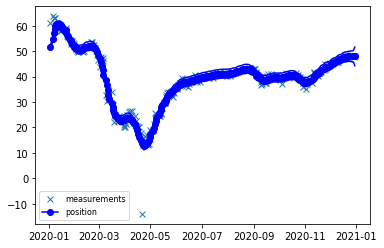

In [109]:
 # Plot KCA's point estimates
 color=['b','g','r']
 pp.plot(t,z,marker='x',linestyle='',label='measurements')
 pp.plot(t,x_point[:,0],marker='o',linestyle='-',label='position', \
 color=color[0])
 pp.plot(t,x_point[:,0]-2*x_bands[:,0],linestyle='-',color=color[0])
 pp.plot(t,x_point[:,0]+2*x_bands[:,0],linestyle='-',color=color[0])
 pp.legend(loc='lower left',prop={'size':8})

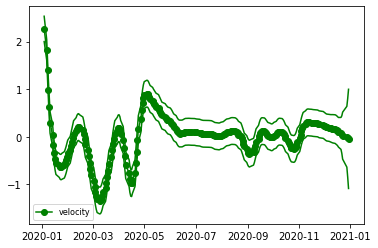

In [110]:
# Plot KCA's estimates for velocity
pp.plot(t,x_point[:,1],marker='o',linestyle='-',label='velocity', \
color=color[1])
pp.plot(t,x_point[:,1]-2*x_bands[:,1],linestyle='-',color=color[1])
pp.plot(t,x_point[:,1]+2*x_bands[:,1],linestyle='-',color=color[1])
pp.legend(loc='lower left',prop={'size':8})

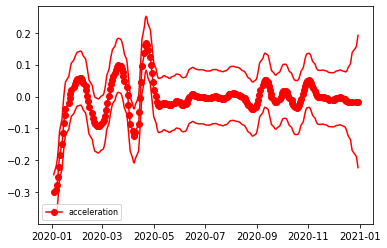

In [111]:
# Plot KCA's estimates for acceleration
pp.plot(t,x_point[:,2],marker='o',linestyle='-',label='acceleration', \
color=color[2])
pp.plot(t,x_point[:,2]-2*x_bands[:,2],linestyle='-',color=color[2])
pp.plot(t,x_point[:,2]+2*x_bands[:,2],linestyle='-',color=color[2])
pp.legend(loc='lower left',prop={'size':8})

Forecasting 20 steps ahead

In [133]:
t = price[:, 0]
z = price[:, 7]
x_point,x_bands = fitKCA(t,z,fwd=20,q=.001)[:2]

In [134]:
fwd = 20
lastdate = t[len(t)-1]
lastdate = pd.to_datetime(lastdate - epoch, unit='D')
horizon = []
for i in range(fwd):
  lastdate = lastdate + timedelta(days=1)
  horizon.append(lastdate)
horizon = pd.DatetimeIndex(horizon).floor('d').to_julian_date()
t = np.append(t, horizon)
t = pd.to_datetime(t - epoch, unit='D')

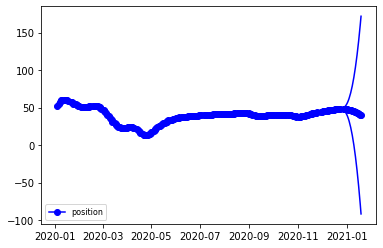

In [135]:
# Plot KCA's point estimates for the forecast
color=['b','g','r']
pp.plot(t,x_point[:,0],marker='o',linestyle='-',label='position', \
color=color[0])
pp.plot(t,x_point[:,0]-2*x_bands[:,0],linestyle='-',color=color[0])
pp.plot(t,x_point[:,0]+2*x_bands[:,0],linestyle='-',color=color[0])
pp.legend(loc='lower left',prop={'size':8})

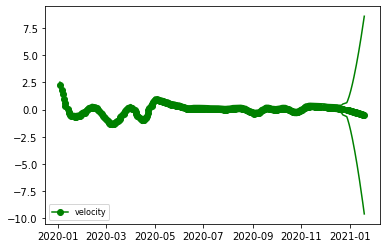

In [136]:
# Plot KCA's estimates for velocity
pp.plot(t,x_point[:,1],marker='o',linestyle='-',label='velocity', \
color=color[1])
pp.plot(t,x_point[:,1]-2*x_bands[:,1],linestyle='-',color=color[1])
pp.plot(t,x_point[:,1]+2*x_bands[:,1],linestyle='-',color=color[1])
pp.legend(loc='lower left',prop={'size':8})

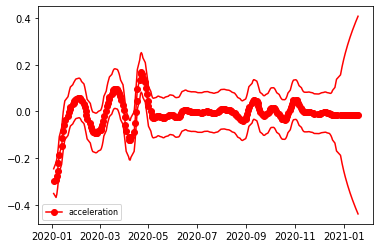

In [137]:
# Plot KCA's estimates for acceleration
pp.plot(t,x_point[:,2],marker='o',linestyle='-',label='acceleration', \
color=color[2])
pp.plot(t,x_point[:,2]-2*x_bands[:,2],linestyle='-',color=color[2])
pp.plot(t,x_point[:,2]+2*x_bands[:,2],linestyle='-',color=color[2])
pp.legend(loc='lower left',prop={'size':8})

**3. GENERATE TRADING SIGNALS FROM KCA**

According to the article, the user is suggested to open a position when the acceleration is significantly different from zero, that is +/- 2 SD different from zero, otherwise there is 'inertia'. From the plots above, we can see that, as in accordance with the paper, most of the futures are for the majority of time in 'inertia'.
After various attempts I came to the conclusion the it would be best to enter a position when the velocity parameter is significantly different from zero instead of acceleration, as this last one anticipate too much market swings


In [141]:
t = price[:, 0]
z = price[:, 7]
x_point,x_bands = fitKCA(t,z,fwd=0,q=.001)[:2]
fullarray = np.concatenate((price, x_point, x_bands), axis=1)
df = pd.DataFrame(fullarray, columns = ['Date','Open','High','Low','Close','Adj Close','Volume','VWAP','Pct','Returns','pPos','pVel','pAcc','bPos','bVel','bAcc'])
df['Date'] = pd.to_datetime(df['Date'] - epoch, unit='D')

In [146]:
position = 0
df['upper_acc']= df['pAcc'] +2*df['bAcc']
df['lower_acc']= df['pAcc'] -2*df['bAcc']
df['upper_vel']= df['pVel'] +2*df['bVel']
df['lower_vel']= df['pVel'] -2*df['bVel']
df['position'] = 0       
for index, row in df.iterrows():
    if ((row["lower_vel"]) > 0) & (position == 0):
      df.loc[index, 'position'] = 1
      position = 1
    if ((row["upper_vel"]) < 0) & (position == 0):
      df.loc[index, 'position'] = -1
      position = -1
    if ((row["upper_vel"]) > 0) & ((row["lower_vel"]) < 0) & (position == 1):
      df.loc[index, 'position'] = -1
      position = 0
    if ((row["upper_vel"]) > 0) & ((row["lower_vel"]) < 0) & (position == -1):
      df.loc[index, 'position'] = 1
      position = 0
alloc = 100
df['net_position'] = df.position.cumsum().shift().fillna(0)
df['change'] = (df.Close.pct_change() * df.net_position + 1).cumprod() * alloc

Now evaluating the performance of the strategy

In [147]:
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 255 #255 trading days in a year
rf = 0.01 #1% risk free rate
returns = df.loc[len(df)-1,'change']
sharpe = sharpe_ratio((df['change']), N, rf)

In [154]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default='colab'
fig = px.line(df, x='Date',
              y='change',
              title=f"Strategy performance:<br>- Max returns: from 100 to {returns}<br>- Sharpe ratio: {sharpe}")
fig.show()

**4. CONSTRUCT TRADING STRATEGY FOR THE END USER**

Here I recap all the libraries used and functions created, so that the final user can just call a function, enter the symbol he is interested into and the start and end date of the period he is looking into

In [149]:
!pip install yfinance
!pip install pykalman
import numpy as np
import yfinance as yf
import pandas as pd
import math, sys
import matplotlib as plt
import matplotlib.pyplot as pp
from pykalman import KalmanFilter
from math import floor
import warnings
from datetime import timedelta, date
import plotly.express as px
import plotly.io as pio
warnings.filterwarnings('ignore')

def vwap(df):
    q = df.Volume.values
    p = df.Open.values
    return df.assign(vwap=(p * q).cumsum() / q.cumsum())

def price(tickers, startdate, enddate):
    df = yf.download(tickers,startdate,enddate)
    price = df.groupby(df.index.date, group_keys=False).apply(vwap) #calculating vwap
    price = price.reset_index()
    price['Date'] = pd.to_datetime(price['Date'])
    price['Date'] = pd.DatetimeIndex(price['Date']).floor('d').to_julian_date()
    price['Pct'] = price['Close'].pct_change() # calculating daily percentage change in price
    price['Returns'] = (price['Pct'] + 1).cumprod() # calculating returns from the start period of observation
    price = price.dropna() # deleting the first row
    array = np.array(price)
    return array

def fitKCA(t,z,q=0.001,fwd=0):    
    '''
    Inputs:
        t: Iterable with time indices
        z: Iterable with measurements
        q: Scalar that multiplies the seed states covariance
        fwd: number of steps to forecast (optional, default=0)
    Output:
        x[0]: smoothed state means of position velocity and acceleration
        x[1]: smoothed state covar of position velocity and acceleration
    Dependencies: numpy, pykalman
    '''
    #1) Set up matrices A,H and a seed for Q
    h=(t[-1]-t[0])/t.shape[0]
    A=np.array([[1,h,.5*h**2],
                [0,1,h],
                [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2) Apply the filter    
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)
    #3) EM estimates
    kf=kf.em(z)
    #4) Smooth
    x_mean,x_covar=kf.smooth(z)
    #5) Forecast
    for fwd_ in range(fwd):
        x_mean_,x_covar_=kf.filter_update(filtered_state_mean=x_mean[-1], \
            filtered_state_covariance=x_covar[-1])
        x_mean=np.append(x_mean,x_mean_.reshape(1,-1),axis=0)
        x_covar_=np.expand_dims(x_covar_,axis=0)
        x_covar=np.append(x_covar,x_covar_,axis=0)
    #6) Std series
    x_std=(x_covar[:,0,0]**.5).reshape(-1,1)
    for i in range(1,x_covar.shape[1]):
        x_std_=x_covar[:,i,i]**.5
        x_std=np.append(x_std,x_std_.reshape(-1,1),axis=1)
    return x_mean,x_std,x_covar

def KCAstrategy(tickers, startdate, enddate):
  for ticker in tickers:
    try:
      df = price(ticker, startdate, enddate)
      t = df[:, 0]
      z = df[:, 7]
      x_point,x_bands = fitKCA(t,z,q=.001)[:2]
      fullarray = np.concatenate((df, x_point, x_bands), axis=1)
      df = pd.DataFrame(fullarray, columns = ['Date','Open','High','Low','Close','Adj Close','Volume','VWAP','Pct','Returns','pPos','pVel','pAcc','bPos','bVel','bAcc'])
      df['Date'] = pd.to_datetime(df['Date'] - epoch, unit='D')
      position = 0
      df['upper_acc']= df['pAcc'] +2*df['bAcc']
      df['lower_acc']= df['pAcc'] -2*df['bAcc']
      df['upper_vel']= df['pVel'] +2*df['bVel']
      df['lower_vel']= df['pVel'] -2*df['bVel']
      df['position'] = 0       
      for index, row in df.iterrows():
          if ((row["lower_vel"]) > 0) & (position == 0):
            df.loc[index, 'position'] = 1
            position = 1
          if ((row["upper_vel"]) < 0) & (position == 0):
            df.loc[index, 'position'] = -1
            position = -1
          if ((row["upper_vel"]) > 0) & ((row["lower_vel"]) < 0) & (position == 1):
            df.loc[index, 'position'] = -1
            position = 0
          if ((row["upper_vel"]) > 0) & ((row["lower_vel"]) < 0) & (position == -1):
            df.loc[index, 'position'] = 1
            position = 0
      alloc = 100
      df['net_position'] = df.position.cumsum().shift().fillna(0)
      df['change'] = (df.Close.pct_change() * df.net_position + 1).cumprod() * alloc
      N = 255 #255 trading days in a year
      rf = 0.01 #1% risk free rate
      returns = df.loc[len(df)-1,'change']
      sharpe = sharpe_ratio((df['change']), N, rf)
      lastdate = df.loc[len(df)-1,'Date']
      #lastdate = pd.to_datetime(lastdate - epoch, unit='D')
      lastdate = lastdate + timedelta(days=1)
      lastposition = df.loc[len(df)-1,'position']
      if lastposition == 1:
        lastaction = 'Buy'
      elif lastposition == 0:
        lastaction = 'Out'
      elif lastposition == -1:
        lastaction = 'Sell' 
      report = f'Returns for {ticker}: {returns}, Sharpe ratio: {sharpe}, suggestion for {lastdate}: {lastaction} '
      print(report)
      pio.renderers.default='colab'
      fig = px.line(df, x='Date',
              y='change',
              title=f"Strategy performance for {ticker}")
      fig.show()
    except:
      pass

In [152]:
tickers = [item for item in input("Enter your tickers of interest: ").split()] #NG=F SI=F ZC=F
startdate = input('Enter the start date in YYYY-MM-DD format')
enddate = input('Enter the end date in YYYY-MM-DD format')

Enter your tickers of interest: NG=F SI=F ZC=F
Enter the start date in YYYY-MM-DD format2021-01-01
Enter the end date in YYYY-MM-DD format2021-10-22


In [153]:
KCAstrategy(tickers, startdate, enddate)

[*********************100%***********************]  1 of 1 completed
Returns for NG=F: 185.31604959758008, Sharpe ratio: 74.87434414751996, suggestion for 2021-10-22 00:00:00: Out 


[*********************100%***********************]  1 of 1 completed
Returns for SI=F: 179.60987726796134, Sharpe ratio: 110.57866198763307, suggestion for 2021-10-22 00:00:00: Sell 


[*********************100%***********************]  1 of 1 completed
Returns for ZC=F: 252.27921675433214, Sharpe ratio: 47.07687263035749, suggestion for 2021-10-22 00:00:00: Out 


**CONCLUSIONS**

The KCA strategy seems to be a promising trading approach, even tough there are several things in the abovementioned approach that can be optimized:
1. the q parameter of the KCA algorithm could be optimized, to find the value that is the best tradeoff between accuracy and overfitting
2. acceleration seems to provide worse results than velocity, but possibly a compehensive approach that considers both may be more accurate in providing trading signals
3. a stop-loss may be an add-on feature whose value need to be evaluated
To conclude, according to the KCA algorithm the symbols considered seem to be most of the time in a state of 'inertia'. Despite this fact, the algorithm seems to be good at identifying abrupt swings in the market and ultimatly it has lead to good trading performances for all the symbols considered.